In [ ]:
!pip install open_clip_torch
!apt-get update -qq -y
!apt-get install --allow-change-held-packages nvidia-cuda-toolkit -qq -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 > /dev/null 2>&1
from transformers import AutoModel, AutoProcessor
import torch
from PIL import Image
import os
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.7 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Extracting templates from packages: 100%
Preconfiguring packages ...
Selecting previously unselected package libdebuginfod-common.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../00-libdebuginfod-common_0.186-1build1_all.deb ...
Unpacking libdebuginfod-common (0.186-1build1) ...
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../01-fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package fonts-dejavu-extra.
Preparing to unpack .../02-fonts-dejavu-extra_2.37-2build1_all.deb ...
Unpacking fonts-deja

In [ ]:
# you should upload kaggle.json with kaggle API token
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [ ]:
# download fashion dataset https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset
!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset
!unzip -q fashion-product-images-dataset.zip
os.remove('fashion-product-images-dataset.zip')

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset
License(s): MIT
100% 23.1G/23.1G [04:50<00:00, 174MB/s]
100% 23.1G/23.1G [04:50<00:00, 85.3MB/s]


In [ ]:
model = AutoModel.from_pretrained('Marqo/marqo-fashionCLIP', trust_remote_code=True).to('cuda')
processor = AutoProcessor.from_pretrained('Marqo/marqo-fashionCLIP', trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

marqo_fashionCLIP.py:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Marqo/marqo-fashionCLIP:
- marqo_fashionCLIP.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
You are using a model of type clip to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

open_clip_model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/532 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

You are using a model of type clip to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/576 [00:00<?, ?B/s]

In [ ]:
model = AutoModel.from_pretrained('Marqo/marqo-fashionCLIP', trust_remote_code=True).to('cuda')
processor = AutoProcessor.from_pretrained('Marqo/marqo-fashionCLIP', trust_remote_code=True)

In [ ]:
img_names = os.listdir('./fashion-dataset/images')
print('Num of images:', len(img_names))
full_features = []
full_images = []
for i in tqdm(range(0, 44_441, 32)):
    images = []
    for img_name in os.listdir('./fashion-dataset/images')[i:i+32]:
        img_path = os.path.join('./fashion-dataset/images', img_name)
        images.append(Image.open(img_path).resize((224, 224)))
    features = model.get_image_features(processor(images=images,return_tensors="pt")['pixel_values'].to('cuda'), normalize=True)
    full_features.extend(features.tolist())
    full_images.extend(images)
full_features = torch.tensor(full_features).to('cuda')

Num of images: 44441


 77%|███████▋  | 1066/1389 [33:36<09:48,  1.82s/it]

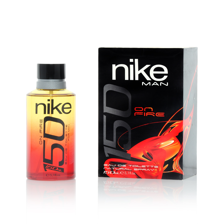

In [ ]:
text = "naked man"
text_features = model.get_text_features(processor(text=text, padding='max_length', return_tensors="pt")['input_ids'].to('cuda'), normalize=True)
idx = (100.0 * full_features @ text_features.T).softmax(dim=0).argmax()
full_images[idx]